In [ ]:
!pip install -q -U transformers bitsandbytes

In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/student project test/GSM_Symbolic_Robustness-main/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/student project test/GSM_Symbolic_Robustness-main/dataset


In [ ]:
config = {
    'model_name': "microsoft/Phi-3.5-mini-instruct",
    'tokenizer_name': 'microsoft/Phi-3.5-mini-instruct',
    'token': 'HF_token',
    'is_mistral_or_llama': False,
    'output_name': 'accuracy_Phi3.5mini_no_finetune_8shot',
    'val_dataset_path': 'GSM_symbolic.jsonl',
    'base_dataset_path': 'GSM8K/test.jsonl'
}

In [ ]:
import dataset_and_dataloader
from transformers import AutoTokenizer
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM
import torch
import re
import numpy as np
from tqdm import tqdm

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config['tokenizer_name'], token = config['token'])
if config['is_mistral_or_llama']:
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
val_dataset = dataset_and_dataloader.GSM8K_Val_Dataset(config['val_dataset_path'], tokenizer)
base_dataset = dataset_and_dataloader.GSM8K_Base_Dataset(config['base_dataset_path'], tokenizer)

In [ ]:
# load in quantization config
q_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

model_name = config["model_name"]

model = AutoModelForCausalLM.from_pretrained(model_name, token=config['token'], quantization_config=q_config)
if config['is_mistral_or_llama']:
  model.config.pad_token_id = tokenizer.pad_token_id

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [ ]:
#free CUDA memory
torch.cuda.empty_cache()
import gc
gc.collect()

1620

In [ ]:
model.to(device)
model.eval()

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLUActivation()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=

In [ ]:
def extract_last_number(text) -> float:
    """Extract the last number from natural language formatted result"""
    cleaned = text.replace(",", "")
    numbers = re.findall(r"-?\d+\.\d+|-?\d+", cleaned)
    if not numbers:
        return 0.0
    last_number = numbers[-1]
    if "." in last_number:
        return float(last_number)
    else:
        i = int(last_number)
        try:
            return float(i)
        except OverflowError:
            return 0.0

In [ ]:
import os
os.makedirs("outputs", exist_ok=True)
raw_out_path = os.path.join("outputs", config['output_name'] + "_raw_outputs.jsonl")
result_file = os.path.join("outputs", config['output_name'] + "_group_results.jsonl")

In [ ]:

import json

# Number of examples to test
test_num = 50

# Output file path
output_path = "outputs/result_Phi3.5mini_8shot_50.jsonl"

# Make sure output directory exists
os.makedirs("outputs", exist_ok=True)

# Counter for correct predictions
predict_right = 0

# Open the output file in write mode (overwrite each run)
with open(output_path, "w", encoding="utf-8") as write_file:

    # Progress bar over test examples
    pbar = tqdm(range(test_num))

    for idx in pbar:
        # Get one example from the dataset
        q, q_mask, a = base_dataset[idx]

        # Convert token ids and attention mask to tensors and move to device
        q_tensor = torch.tensor(q).unsqueeze(0).to(device)
        q_mask_tensor = torch.tensor(q_mask).unsqueeze(0).to(device)

        # Run model inference (no gradient needed for evaluation)
        with torch.no_grad():
            pred_ids = model.generate(
                input_ids=q_tensor,
                attention_mask=q_mask_tensor,
                max_new_tokens=256
            )

        # Remove the prompt tokens and keep only newly generated tokens
        gen_tokens = pred_ids[:, q_tensor.shape[-1]:]

        # Decode generated tokens to text (batch size = 1)
        output_text = tokenizer.decode(
            gen_tokens[0],
            skip_special_tokens=True
        )

        # Extract numeric answers from prediction and ground truth
        pred_ans = extract_last_number(str(output_text))
        corr_ans = extract_last_number(str(a))

        # Check correctness with a small tolerance
        is_correct = False
        try:
            is_correct = abs(pred_ans - corr_ans) <= 1e-4
        except Exception:
            is_correct = False

        # Update correct prediction counter
        if is_correct:
            predict_right += 1

        # Write prediction result to JSONL file (one record per line)
        write_file.write(
            json.dumps(
                {
                    "model_prediction": output_text,
                    "predict_value": pred_ans,
                    "gold_value": corr_ans,
                    "correct": is_correct
                },
                ensure_ascii=False
            )
            + "\n"
        )

        # Flush to ensure data is written to disk immediately
        write_file.flush()

        # Update progress bar with running accuracy
        pbar.set_postfix(
            {"running_acc": f"{predict_right / (idx + 1):.3f}"}
        )

# Print final statistics
base_acc = predict_right / test_num
print(f"Correct Predictions: {predict_right}")
print(f"Total Examples: {test_num}")
print(f"Accuracy: {predict_right / test_num:.2f}")
print(f"Results written to: {output_path}")

100%|██████████| 50/50 [14:24<00:00, 17.29s/it, running_acc=0.760]

Correct Predictions: 38
Total Examples: 50
Accuracy: 0.76
Results written to: outputs/result_Phi3.5mini_8shot_50.jsonl


In [52]:
import json
from collections import defaultdict

records = []
results_by_variant_idx = defaultdict(list)
num_templates = 50
num_variants = 10

pbar = tqdm(range(len(val_dataset)))
for idx in pbar:

    q_id, instance, q, q_mask, a = val_dataset[idx]

    q_id = int(q_id)
    instance = int(instance)
    if q_id >= num_templates:
      break
    if instance >= num_variants:
      continue

    q_tensor = torch.tensor(q).unsqueeze(0).to(device)
    q_mask_tensor = torch.tensor(q_mask).unsqueeze(0).to(device)

    # Inference (use no_grad to save memory)
    with torch.no_grad():
        pred_ids = model.generate(
            input_ids=q_tensor,
            attention_mask=q_mask_tensor,
            max_new_tokens=256
        )
    # decode only generated portion (cut off prompt length)
    gen_tokens = pred_ids[:, q_tensor.shape[-1]:]
    output_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

    # Extract numeric values using provided function
    pred_ans = extract_last_number(output_text)
    corr_ans = extract_last_number(a)

    # Consider a prediction correct if numeric values match within tolerance
    is_correct = abs(pred_ans - corr_ans) < 1e-4

    results_by_variant_idx[instance].append(bool(is_correct))

    # update progress text (running accuracy across all recorded so far)
    item_record = {
        "id": q_id,
        "instance": instance,
        "output": output_text,
        "pred_value": pred_ans,
        "corr_value": corr_ans,
        "correct": bool(is_correct)
    }
    records.append(item_record)

    with open(raw_out_path, "a", encoding="utf-8") as raw_f:
        raw_f.write(json.dumps(item_record, ensure_ascii=False) + "\n")

    done = len(records)
    running_acc = sum(1 for r in records if r["correct"]) / done if done>0 else 0.0
    pbar.set_postfix({"running_acc": f"{running_acc:.3f}"})


with open(result_file, "w", encoding="utf-8") as write_file:
    group_accuracies = []
    for v_idx in range(num_variants):
        per_list = results_by_variant_idx.get(v_idx, [])
        total_questions = len(per_list)
        corr_preds = sum(1 for x in per_list if x is True)

        accuracy = corr_preds / total_questions if total_questions > 0 else 0.0

        group_result = {
            "group_index": v_idx + 1,
            "accuracy": accuracy,
            "total_questions": total_questions,
            "correct_predictions": corr_preds,
        }
        write_file.write(json.dumps(group_result, ensure_ascii=False) + "\n")
        group_accuracies.append(group_result)

 50%|█████     | 2500/5000 [2:25:19<2:25:19,  3.49s/it, running_acc=0.718] 


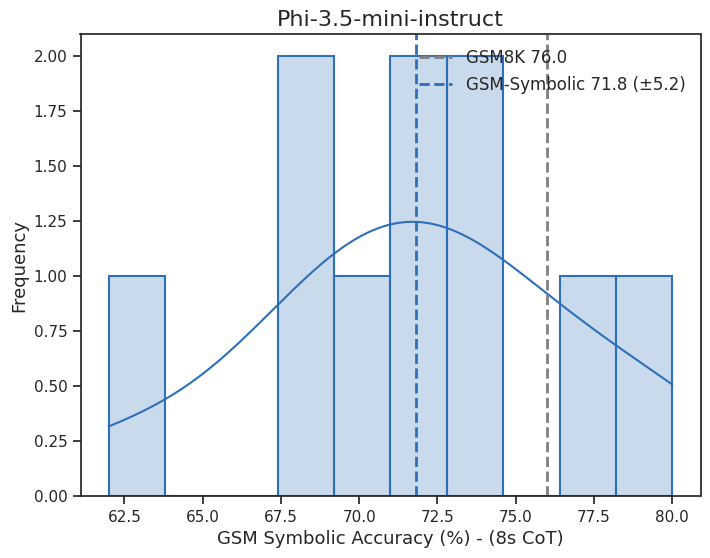

In [56]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ======================
# File path
# ======================
file_path = "outputs/accuracy_Phi3.5mini_8shot_group_results.jsonl"

# ======================
# 1. Load GSM-Symbolic accuracy data
# ======================
accuracies = []

# Read the JSONL file line by line
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        record = json.loads(line.strip())
        # Convert accuracy to percentage
        accuracies.append(record["accuracy"] * 100)

accuracies = np.array(accuracies)

# ======================
# 2. Compute statistics
# ======================
# Mean accuracy
mean_accuracy = accuracies.mean()

# Standard deviation (sample std, more appropriate for reporting)
std_accuracy = accuracies.std(ddof=1)

# GSM8K baseline accuracy (percentage)
gsm8k_accuracy = base_acc * 100

# ======================
# 3. Plot distribution
# ======================
sns.set_theme(style="ticks")

# Color similar to the paper figure
color = "#2E6FBA"

plt.figure(figsize=(8, 6))

# Histogram with KDE
sns.histplot(
    accuracies,
    kde=True,
    bins=10,
    color=color,
    edgecolor=color,
    linewidth=1.5,
    alpha=0.25,
)

# ======================
# 4. Reference lines
# ======================
# GSM8K baseline
plt.axvline(
    x=gsm8k_accuracy,
    color="gray",
    linestyle="--",
    linewidth=2,
    label=f"GSM8K {gsm8k_accuracy:.1f}",
)

# GSM-Symbolic mean with standard deviation
plt.axvline(
    x=mean_accuracy,
    color=color,
    linestyle="--",
    linewidth=2,
    label=f"GSM-Symbolic {mean_accuracy:.1f} (±{std_accuracy:.1f})",
)

# ======================
# 5. Title and axis labels
# ======================
plt.title("Phi-3.5-mini-instruct", fontsize=16)
plt.xlabel("GSM Symbolic Accuracy (%) - (8s CoT)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)

# ======================
# 6. Legend
# ======================
plt.legend(frameon=False, fontsize=12, loc="upper right")

# ======================
# 7. Save and display the figure
# ======================
output_file = "accuracy_distribution_Phi3.5_mini_symbolic.png"
plt.savefig(output_file, dpi=300, bbox_inches="tight")
plt.show()
